## Data loading

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import json

import regex as re
from python_proj.utils.util import safe_save_fig, subtract_dict, Counter
import python_proj.utils.exp_utils as exp_utils

file_name = "dataset_90_days_started_11_07_23_preprocessed"
base_path = exp_utils.BASE_PATH
data_path = f'{base_path}/final_data/{file_name}.csv'
figure_base_path = f"{base_path}/figures/modelling/{file_name}/rf_ftc_dependency/"

# Meta stuff.
pr_merged_key = 'PullRequestIsMerged'
ftc_key = 'SubmitterIsFirstTimeContributor'
seed_counter = Counter()


# Loads regular dataframe.
df: pd.DataFrame = pd.read_csv(filepath_or_buffer=data_path, header=0)
if 'Unnamed: 1' in df.columns:
    df = df.drop(['Unnamed: 1', "Project Name.1"], axis=1)
print(df.columns)

# Creates sub-datasets.
metadata_fields = ['ID', 'Project Name',
                   'Submitter ID', 'PR Number', 'Closed At']
dependent_fields = [pr_merged_key]
independent_fields = [field for field in df.columns
                      if (field not in metadata_fields
                          and field != pr_merged_key)]

df[independent_fields].describe()

class_counts = df[pr_merged_key].value_counts()
class_imbalance = class_counts[True] / class_counts[False]
print(f'{class_imbalance=}')

Index(['Project Name', 'ID', 'Submitter ID', 'PR Number', 'Closed At',
       'PullRequestIsMerged', 'ControlIntegratedBySameUser',
       'ControlPullRequestHasComments', 'ControlHasHashTagInDescription',
       'IntraProjectSubmitterPullRequestSuccessRate',
       'EcosystemExperienceSubmitterPullRequestSuccessRate',
       'DependencyEcosystemExperienceSubmitterPullRequestSuccessRate',
       'InversedDependencyEcosystemExperienceSubmitterPullRequestSuccessRate',
       'SubmitterIsFirstTimeContributor',
       'ControlPullRequestHasCommentByExternalUser',
       'ln(1 + ControlPullRequestLifeTimeInMinutes)',
       'ln(1 + ControlNumberOfCommitsInPullRequest)',
       'ln(1 + ControlIntraProjectPullRequestExperienceOfIntegrator)',
       'ln(1 + IntraProjectSubmitterPullRequestSubmissionCount)',
       'ln(1 + IntraProjectSubmitterPullRequestCommentCount)',
       'ln(1 + EcosystemExperienceSubmitterPullRequestSubmissionCount)',
       'ln(1 + EcosystemExperienceSubmitterPullReques

In [2]:
# FTC selection

df = df[df[ftc_key] == True]
not_applicable_fields = [ftc_key]
df = df.drop(not_applicable_fields, axis=1)
independent_fields = [field for field in df.columns
                      if (field not in metadata_fields
                          and field != pr_merged_key
                          and field not in not_applicable_fields)]
print(len(df))

class_counts = df[pr_merged_key].value_counts()
class_imbalance = class_counts[True] / class_counts[False]
print(f'{class_imbalance=}')

df = df.reset_index(drop=True)
print(independent_fields)
df.describe()


428437
class_imbalance=1.9303653748820158
['ControlIntegratedBySameUser', 'ControlPullRequestHasComments', 'ControlHasHashTagInDescription', 'IntraProjectSubmitterPullRequestSuccessRate', 'EcosystemExperienceSubmitterPullRequestSuccessRate', 'DependencyEcosystemExperienceSubmitterPullRequestSuccessRate', 'InversedDependencyEcosystemExperienceSubmitterPullRequestSuccessRate', 'ControlPullRequestHasCommentByExternalUser', 'ln(1 + ControlPullRequestLifeTimeInMinutes)', 'ln(1 + ControlNumberOfCommitsInPullRequest)', 'ln(1 + ControlIntraProjectPullRequestExperienceOfIntegrator)', 'ln(1 + IntraProjectSubmitterPullRequestSubmissionCount)', 'ln(1 + IntraProjectSubmitterPullRequestCommentCount)', 'ln(1 + EcosystemExperienceSubmitterPullRequestSubmissionCount)', 'ln(1 + EcosystemExperienceSubmitterPullRequestCommentCount)', 'ln(1 + DependencyEcosystemExperienceSubmitterPullRequestSubmissionCount)', 'ln(1 + DependencyEcosystemExperienceSubmitterPullRequestCommentCount)', 'ln(1 + InversedDependenc

,ID,Submitter ID,PR Number,IntraProjectSubmitterPullRequestSuccessRate,EcosystemExperienceSubmitterPullRequestSuccessRate,DependencyEcosystemExperienceSubmitterPullRequestSuccessRate,InversedDependencyEcosystemExperienceSubmitterPullRequestSuccessRate,ln(1 + ControlPullRequestLifeTimeInMinutes),ln(1 + ControlNumberOfCommitsInPullRequest),ln(1 + ControlIntraProjectPullRequestExperienceOfIntegrator),...,ln(1 + EcosystemExperienceSubmitterIssueSubmissionCount),ln(1 + EcosystemExperienceSubmitterIssueCommentCount),ln(1 + DependencyEcosystemExperienceSubmitterIssueSubmissionCount),ln(1 + DependencyEcosystemExperienceSubmitterIssueCommentCount),ln(1 + InversedDependencyEcosystemExperienceSubmitterIssueSubmissionCount),ln(1 + InversedDependencyEcosystemExperienceSubmitterIssueCommentCount),ln(1 + WeightedFirstOrderInDegreeCentrality),ln(1 + WeightedFirstOrderOutDegreeCentrality),ln(1 + IntegratorToSubmitterLinkIntensity),ln(1 + SubmitterToIntegratorLinkIntensity)
count,4.284370e+05,4.284370e+05,428437.000000,428437.000000,428437.000000,428437.000000,428437.000000,428437.000000,428437.000000,428437.000000,...,428437.000000,428437.000000,428437.000000,428437.000000,428437.000000,428437.000000,428437.000000,428437.000000,428437.000000,428437.000000
mean,1.214539e+08,5.136409e+06,583.307070,0.000002,0.265750,0.024008,0.024890,0.491620,0.106407,0.198938,...,0.060220,0.098393,0.002779,0.004935,0.004179,0.007883,0.041560,0.031838,0.011340,0.015211
std,9.547123e+07,8.025027e+06,1717.264418,0.001528,0.409667,0.149793,0.150771,0.223163,0.060840,0.165355,...,0.104343,0.153478,0.025492,0.040208,0.033541,0.054325,0.075803,0.067460,0.048285,0.055116
min,1.153000e+03,1.000000e+00,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.801914e+07,4.987750e+05,30.000000,0.000000,0.000000,0.000000,0.000000,0.334641,0.075257,0.082923,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.012219e+08,1.678902e+06,122.000000,0.000000,0.000000,0.000000,0.000000,0.503314,0.075257,0.165846,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.890565e+08,6.316590e+06,469.000000,0.000000,0.666667,0.000000,0.000000,0.662196,0.119279,0.306852,...,0.089382,0.155067,0.000000,0.000000,0.000000,0.000000,0.053430,0.031879,0.000000,0.000000
max,3.617726e+08,5.973444e+07,82976.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.991972,...,1.000000,1.000000,0.759557,1.000000,1.000000,0.999543,0.905874,0.880496,0.740970,0.756571


In [3]:
# Select dependency entries.

from python_proj.utils.util import get_matching
dependency_fields = list(get_matching(independent_fields, r'.*(?=Dependency).*'))
print(dependency_fields)

df = df[(df[dependency_fields].gt(0)).any(axis=1)]

print(len(df))
df = df.reset_index(drop=True)
df.describe()

['DependencyEcosystemExperienceSubmitterPullRequestSuccessRate', 'InversedDependencyEcosystemExperienceSubmitterPullRequestSuccessRate', 'ln(1 + DependencyEcosystemExperienceSubmitterPullRequestSubmissionCount)', 'ln(1 + DependencyEcosystemExperienceSubmitterPullRequestCommentCount)', 'ln(1 + InversedDependencyEcosystemExperienceSubmitterPullRequestSubmissionCount)', 'ln(1 + InversedDependencyEcosystemExperienceSubmitterPullRequestCommentCount)', 'ln(1 + DependencyEcosystemExperienceSubmitterIssueSubmissionCount)', 'ln(1 + DependencyEcosystemExperienceSubmitterIssueCommentCount)', 'ln(1 + InversedDependencyEcosystemExperienceSubmitterIssueSubmissionCount)', 'ln(1 + InversedDependencyEcosystemExperienceSubmitterIssueCommentCount)']
30236


,ID,Submitter ID,PR Number,IntraProjectSubmitterPullRequestSuccessRate,EcosystemExperienceSubmitterPullRequestSuccessRate,DependencyEcosystemExperienceSubmitterPullRequestSuccessRate,InversedDependencyEcosystemExperienceSubmitterPullRequestSuccessRate,ln(1 + ControlPullRequestLifeTimeInMinutes),ln(1 + ControlNumberOfCommitsInPullRequest),ln(1 + ControlIntraProjectPullRequestExperienceOfIntegrator),...,ln(1 + EcosystemExperienceSubmitterIssueSubmissionCount),ln(1 + EcosystemExperienceSubmitterIssueCommentCount),ln(1 + DependencyEcosystemExperienceSubmitterIssueSubmissionCount),ln(1 + DependencyEcosystemExperienceSubmitterIssueCommentCount),ln(1 + InversedDependencyEcosystemExperienceSubmitterIssueSubmissionCount),ln(1 + InversedDependencyEcosystemExperienceSubmitterIssueCommentCount),ln(1 + WeightedFirstOrderInDegreeCentrality),ln(1 + WeightedFirstOrderOutDegreeCentrality),ln(1 + IntegratorToSubmitterLinkIntensity),ln(1 + SubmitterToIntegratorLinkIntensity)
count,3.023600e+04,3.023600e+04,30236.000000,30236.0,30236.000000,30236.000000,30236.000000,30236.000000,30236.000000,30236.000000,...,30236.000000,30236.000000,30236.000000,30236.000000,30236.000000,30236.000000,30236.000000,30236.000000,30236.000000,30236.000000
mean,1.305485e+08,3.593413e+06,196.372834,0.0,0.735795,0.340183,0.352692,0.431632,0.107192,0.146511,...,0.184031,0.293180,0.039372,0.069935,0.059222,0.111699,0.117622,0.096583,0.057723,0.072879
std,9.266116e+07,6.433887e+06,739.809783,0.0,0.336816,0.458680,0.454420,0.211967,0.059082,0.144799,...,0.147312,0.196164,0.088134,0.135510,0.112611,0.173847,0.100679,0.098986,0.113932,0.125144
min,6.235100e+04,4.000000e+00,1.000000,0.0,0.000000,0.000000,0.000000,0.001063,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5.100537e+07,2.833135e+05,10.000000,0.0,0.639615,0.000000,0.000000,0.266932,0.075257,0.000000,...,0.089382,0.122888,0.000000,0.000000,0.000000,0.000000,0.043226,0.022306,0.000000,0.000000
50%,1.112827e+08,1.016458e+06,36.000000,0.0,0.882353,0.000000,0.000000,0.449195,0.075257,0.131430,...,0.178763,0.295197,0.000000,0.000000,0.000000,0.000000,0.092797,0.067880,0.000000,0.000000
75%,1.983145e+08,4.093559e+06,130.000000,0.0,1.000000,1.000000,0.956522,0.591073,0.119279,0.232795,...,0.283333,0.444106,0.000000,0.101441,0.104874,0.174931,0.167179,0.138550,0.058131,0.097937
max,3.611003e+08,5.746356e+07,26236.000000,0.0,1.000000,1.000000,1.000000,0.980358,0.898505,0.774675,...,0.852279,0.886324,0.759557,1.000000,1.000000,0.999543,0.799426,0.778250,0.740274,0.756571


## Model Creation

### Re-usable Functions

To create a random forest model and to perform k-fold cross validation.

In [4]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import f1_score, confusion_matrix, classification_report, accuracy_score, precision_score, recall_score


def calculate_metrics(predicted_labels, true_labels, sample_weights=None):
    return {
        "accuracy": accuracy_score(true_labels, predicted_labels, sample_weight=sample_weights),
        "precision": precision_score(true_labels, predicted_labels, sample_weight=sample_weights),
        "recall": recall_score(true_labels, predicted_labels, sample_weight=sample_weights),
        "f1": f1_score(true_labels, predicted_labels, sample_weight=sample_weights)
    }


def create_model(
    train_predictors: pd.DataFrame,
    train_labels: pd.Series,
    test_predictors: pd.DataFrame,
    test_labels: pd.Series,
    random_state: int | None = None,
):
    # Model creation and predictions.
    if random_state is None:
        random_state = seed_counter.get_next()
    print(f'{random_state=}')
    rf = RandomForestRegressor(
        n_estimators=100,
        random_state=random_state)

    rf.fit(train_predictors, train_labels)

    predictions = rf.predict(test_predictors)
    predictions = [pred >= 0.5 for pred in predictions]

    # F1 scores.
    conf = confusion_matrix(test_labels, predictions)

    metrics = calculate_metrics(predictions, test_labels)

    print(f'{metrics=}\n')

    # Other metrics.
    print(f'Confusion matrix:\n{conf}\n')
    print("Classification report:")
    print(classification_report(test_labels, predictions))

    return rf, metrics


In [5]:
from typing import Iterator
import regex as re
from sklearn.model_selection import KFold
from python_proj.utils.mt_utils import parallelize_tasks


def kfold_rf_evaluation(
    _df: pd.DataFrame,
    predictor_fields: Iterator[str],
    k: int = 5
):
    random_state = seed_counter.get_next()

    def create_model_for_fold(task, *args, **kwargs):
        train_idx, test_idx = task
        train = _df.loc[train_idx, :]
        test = _df.loc[test_idx, :]
        train_predictors = train[predictor_fields]
        train_labels = train[pr_merged_key]
        test_predictors = test[predictor_fields]
        test_labels = test[pr_merged_key]
        _, rf_metrics = create_model(
            train_predictors,
            train_labels,
            test_predictors,
            test_labels,
            random_state
        )
        return rf_metrics

    kf = KFold(
        n_splits=k,
        shuffle=True,
        random_state=seed_counter.get_next()
    )
    tasks = kf.split(_df)
    models_and_f1s = parallelize_tasks(
        tasks,
        create_model_for_fold,
        thread_count=min(k, 12),
        return_results=True,
        print_lifetime_events=False
    )

    f1_scores = [entry['f1'] for entry in models_and_f1s]
    f1_mean = np.mean(f1_scores)
    f1_std = np.std(f1_scores)

    return f1_scores, f1_mean, f1_std


### Full Model

In [6]:
f1_scores, f1_mean, f1_std = kfold_rf_evaluation(
    df, independent_fields)

print("\nPerformance metrics full model:")
print(f'{f1_scores=}')
print(f'{f1_mean=}, {f1_std=}')


random_state=43random_state=43random_state=43random_state=43random_state=43




metrics={'accuracy': 0.8351521164021164, 'precision': 0.8541123930033495, 'recall': 0.9556527170518426, 'f1': 0.9020339982313059}

Confusion matrix:
[[ 461  784]
 [ 213 4590]]

Classification report:
              precision    recall  f1-score   support

       False       0.68      0.37      0.48      1245
        True       0.85      0.96      0.90      4803

    accuracy                           0.84      6048
   macro avg       0.77      0.66      0.69      6048
weighted avg       0.82      0.84      0.82      6048

metrics={'accuracy': 0.8387630229866049, 'precision': 0.8625911385305665, 'recall': 0.9505562422744128, 'f1': 0.9044398706262864}

Confusion matrix:
[[ 458  735]
 [ 240 4614]]
metrics={'accuracy': 0.8318174301306432, 'precision': 0.8542996620352985, 'recall': 0.9496973491964099, 'f1': 0.8994761292873381}


Classification report:
Confusion matrix:
[[ 480  776]
 [ 241 4550]]

Classification r

### Control + Intra-project Model

In [7]:
# Creates control model + Intra fields.
contr_with_intra = [field for field in independent_fields
                    if re.match(r'.*(Control|Intra).*',field)]
contr_with_intra = list(contr_with_intra)
print(contr_with_intra)

f1_scores, f1_mean, f1_std = kfold_rf_evaluation(df, contr_with_intra)

print("\nPerformance metrics control + intra model:")
print(f'{f1_scores=}')
print(f'{f1_mean=}, {f1_std=}')

['ControlIntegratedBySameUser', 'ControlPullRequestHasComments', 'ControlHasHashTagInDescription', 'IntraProjectSubmitterPullRequestSuccessRate', 'ControlPullRequestHasCommentByExternalUser', 'ln(1 + ControlPullRequestLifeTimeInMinutes)', 'ln(1 + ControlNumberOfCommitsInPullRequest)', 'ln(1 + ControlIntraProjectPullRequestExperienceOfIntegrator)', 'ln(1 + IntraProjectSubmitterPullRequestSubmissionCount)', 'ln(1 + IntraProjectSubmitterPullRequestCommentCount)', 'ln(1 + IntraProjectSubmitterIssueSubmissionCount)', 'ln(1 + IntraProjectSubmitterIssueCommentCount)']
random_state=45random_state=45random_state=45

random_state=45

random_state=45
metrics={'accuracy': 0.8052248677248677, 'precision': 0.8544537162817776, 'recall': 0.9114055061063961, 'f1': 0.8820112179487178}

Confusion matrix:
[[ 467  750]
 [ 428 4403]]

Classification report:
              precision    recall  f1-score   support

       False       0.52      0.38      0.44      1217
        True       0.85      0.91      0.88

### Collaboration and Ecosystem Model

In [8]:
# Creates measured information model.
non_control_fields_wo_intra = [field for field in independent_fields
                               if not re.match(r'.*(Intra|Control).*', field)]
non_control_fields_wo_intra = list(non_control_fields_wo_intra)
print(non_control_fields_wo_intra)

f1_scores, f1_mean, f1_std = kfold_rf_evaluation(df, non_control_fields_wo_intra)

print("\nPerformance metrics non-control model:")
print(f'{f1_scores=}')
print(f'{f1_mean=}, {f1_std=}')

['EcosystemExperienceSubmitterPullRequestSuccessRate', 'DependencyEcosystemExperienceSubmitterPullRequestSuccessRate', 'InversedDependencyEcosystemExperienceSubmitterPullRequestSuccessRate', 'ln(1 + EcosystemExperienceSubmitterPullRequestSubmissionCount)', 'ln(1 + EcosystemExperienceSubmitterPullRequestCommentCount)', 'ln(1 + DependencyEcosystemExperienceSubmitterPullRequestSubmissionCount)', 'ln(1 + DependencyEcosystemExperienceSubmitterPullRequestCommentCount)', 'ln(1 + InversedDependencyEcosystemExperienceSubmitterPullRequestSubmissionCount)', 'ln(1 + InversedDependencyEcosystemExperienceSubmitterPullRequestCommentCount)', 'ln(1 + EcosystemExperienceSubmitterIssueSubmissionCount)', 'ln(1 + EcosystemExperienceSubmitterIssueCommentCount)', 'ln(1 + DependencyEcosystemExperienceSubmitterIssueSubmissionCount)', 'ln(1 + DependencyEcosystemExperienceSubmitterIssueCommentCount)', 'ln(1 + InversedDependencyEcosystemExperienceSubmitterIssueSubmissionCount)', 'ln(1 + InversedDependencyEcosyste

## Feature Explanation and Evaluation

### Partial Dependence Plots

In [9]:
from sklearn.inspection import PartialDependenceDisplay
from matplotlib import pyplot as plt


def create_partial_dependence_plots(
        rf_model: RandomForestRegressor,
        used_predictors: pd.DataFrame,
        model_name: str = ""):

    # Collective partial dependence plot.
    PartialDependenceDisplay.from_estimator(
        rf_model, used_predictors, used_predictors.columns,
        percentiles=(0.01,0.99))

    fig = plt.gcf()
    axs = fig.axes

    lines = []
    for ax in axs:
        __lines = list([(line.get_xdata(), line.get_ydata())
                        for line in ax.lines])
        lines.extend(__lines)

    for (x, y), label in zip(lines, used_predictors.columns):
        plt.clf()
        plt.plot(x, y, linestyle='-', color='#e69d00')
        plt.xlabel(label)
        plt.ylabel('Partial Dependence')
        plt.tight_layout()
        output_path = f"{figure_base_path}/partial-dependence/{model_name}/{label}.png"
        safe_save_fig(output_path)


In [10]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.2, shuffle=True)
train_predictors = train[independent_fields]
train_dependent = train[pr_merged_key]
test_predictors = test[independent_fields]
test_dependent = test[pr_merged_key]


random_state=49
metrics={'accuracy': 0.8402777777777778, 'precision': 0.8561325144239718, 'recall': 0.9597329438764866, 'f1': 0.904977375565611}

Confusion matrix:
[[ 482  773]
 [ 193 4600]]

Classification report:
              precision    recall  f1-score   support

       False       0.71      0.38      0.50      1255
        True       0.86      0.96      0.90      4793

    accuracy                           0.84      6048
   macro avg       0.79      0.67      0.70      6048
weighted avg       0.83      0.84      0.82      6048



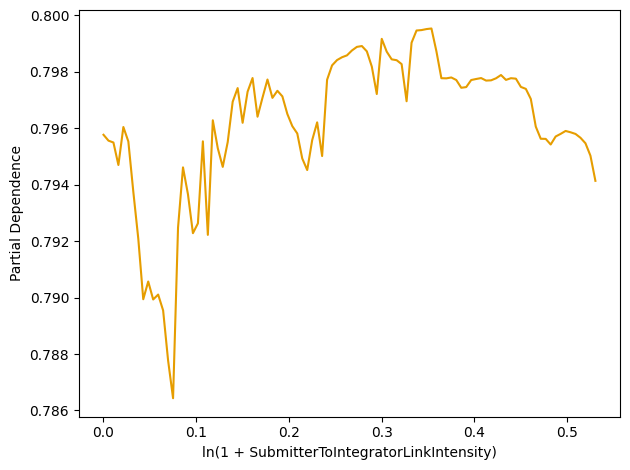

In [11]:
full_rf_model, _ = create_model(
    train_predictors, train_dependent,
    test_predictors, test_dependent
)

create_partial_dependence_plots(
    full_rf_model,
    test_predictors,
    model_name="full_model"
)


### Mean decrease in Impurity

/tmp/ipykernel_90778/2882849337.py:14: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


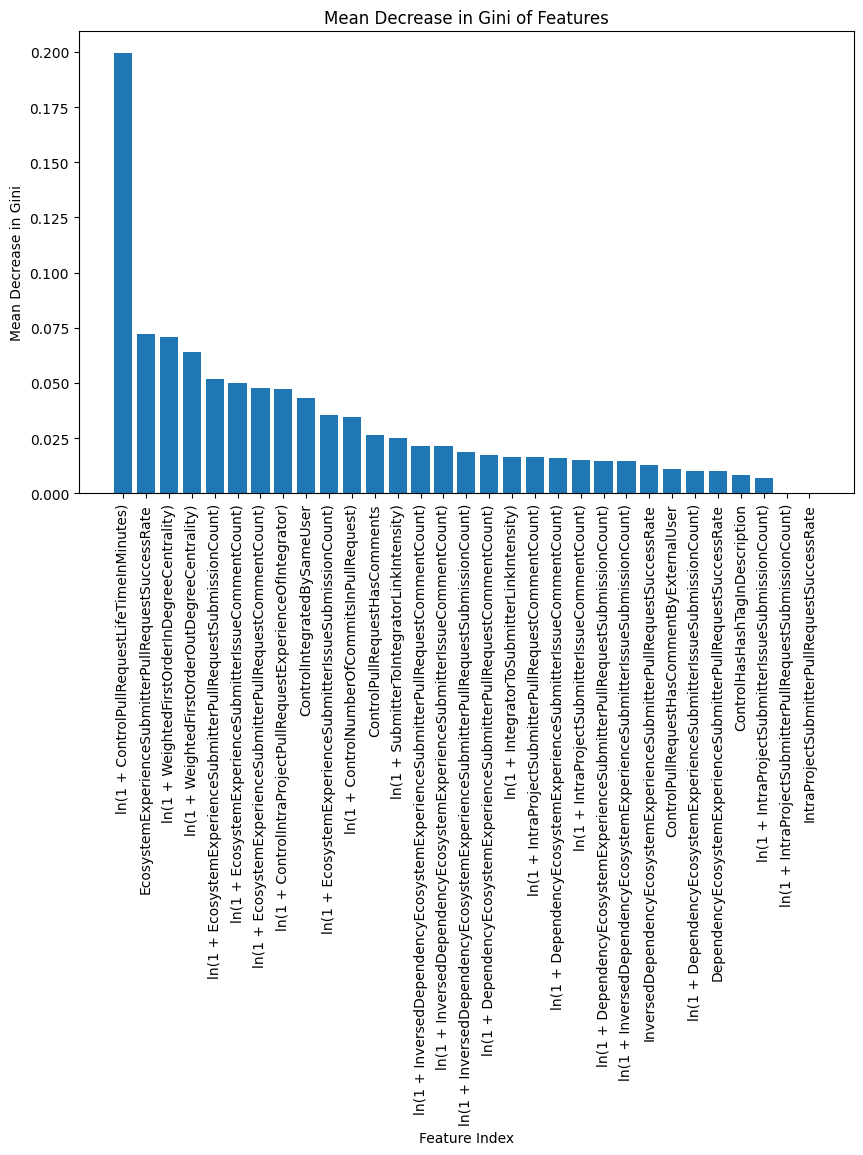

ln(1 + ControlPullRequestLifeTimeInMinutes): 0.1993
EcosystemExperienceSubmitterPullRequestSuccessRate: 0.0724
ln(1 + WeightedFirstOrderInDegreeCentrality): 0.0709
ln(1 + WeightedFirstOrderOutDegreeCentrality): 0.0642
ln(1 + EcosystemExperienceSubmitterPullRequestSubmissionCount): 0.0519
ln(1 + EcosystemExperienceSubmitterIssueCommentCount): 0.0500
ln(1 + EcosystemExperienceSubmitterPullRequestCommentCount): 0.0476
ln(1 + ControlIntraProjectPullRequestExperienceOfIntegrator): 0.0471
ControlIntegratedBySameUser: 0.0431
ln(1 + EcosystemExperienceSubmitterIssueSubmissionCount): 0.0354
ln(1 + ControlNumberOfCommitsInPullRequest): 0.0346
ControlPullRequestHasComments: 0.0265
ln(1 + SubmitterToIntegratorLinkIntensity): 0.0251
ln(1 + InversedDependencyEcosystemExperienceSubmitterPullRequestCommentCount): 0.0215
ln(1 + InversedDependencyEcosystemExperienceSubmitterIssueCommentCount): 0.0215
ln(1 + InversedDependencyEcosystemExperienceSubmitterPullRequestSubmissionCount): 0.0186
ln(1 + Dependen

In [12]:
feature_importances = full_rf_model.feature_importances_

sorted_indices = np.argsort(feature_importances)[::-1]
sorted_importances = feature_importances[sorted_indices]

# Step 4: Plot the mean decrease accuracy plot
plt.figure(figsize=(10, 6))
plt.bar(range(test_predictors.shape[1]), sorted_importances)
plt.xlabel('Feature Index')
plt.ylabel('Mean Decrease in Gini')
plt.title('Mean Decrease in Gini of Features')
ordererd_columns = np.array(test_predictors.columns)[sorted_indices]
plt.xticks(range(test_predictors.shape[1]), ordererd_columns, rotation=90)
plt.tight_layout()
plt.show()

for field, importance in zip(ordererd_columns, sorted_importances):
    print(f'{field}: {importance:.04f}')


/tmp/ipykernel_90778/3418580621.py:18: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


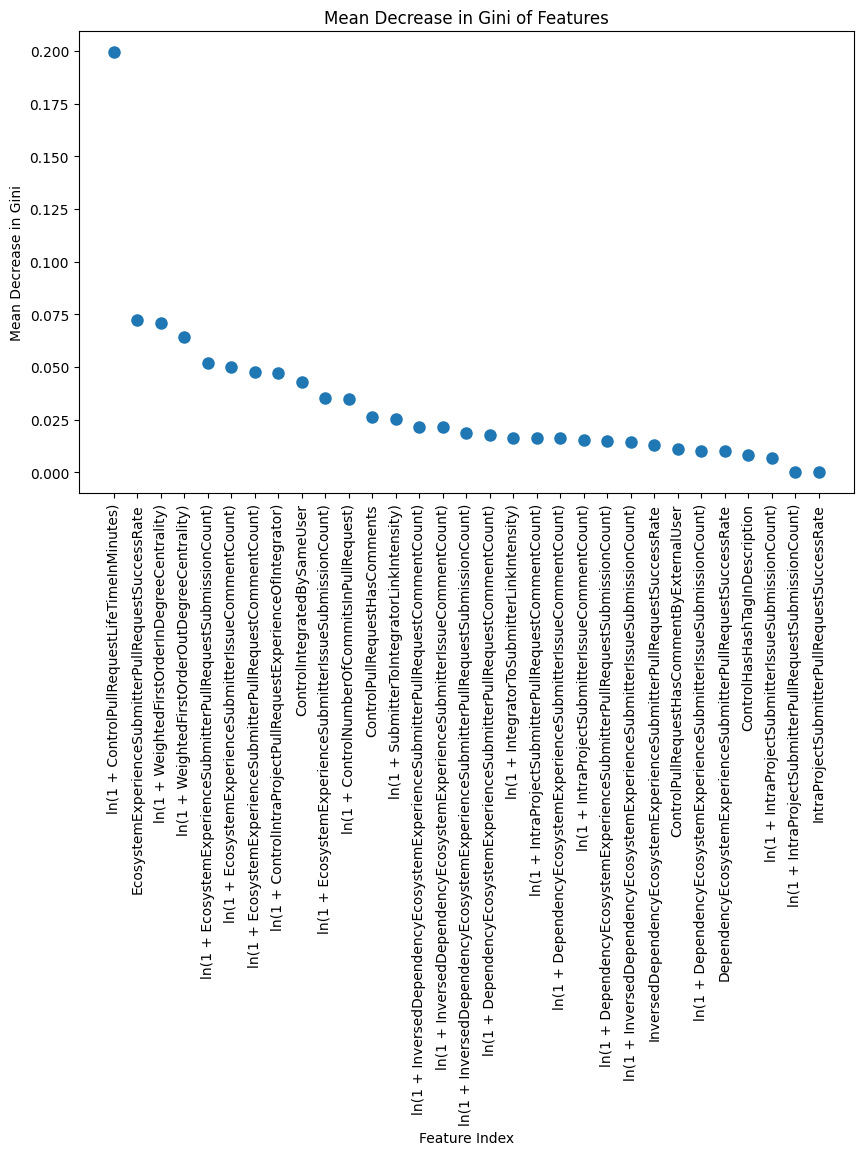

ln(1 + ControlPullRequestLifeTimeInMinutes): 0.1993
EcosystemExperienceSubmitterPullRequestSuccessRate: 0.0724
ln(1 + WeightedFirstOrderInDegreeCentrality): 0.0709
ln(1 + WeightedFirstOrderOutDegreeCentrality): 0.0642
ln(1 + EcosystemExperienceSubmitterPullRequestSubmissionCount): 0.0519
ln(1 + EcosystemExperienceSubmitterIssueCommentCount): 0.0500
ln(1 + EcosystemExperienceSubmitterPullRequestCommentCount): 0.0476
ln(1 + ControlIntraProjectPullRequestExperienceOfIntegrator): 0.0471
ControlIntegratedBySameUser: 0.0431
ln(1 + EcosystemExperienceSubmitterIssueSubmissionCount): 0.0354
ln(1 + ControlNumberOfCommitsInPullRequest): 0.0346
ControlPullRequestHasComments: 0.0265
ln(1 + SubmitterToIntegratorLinkIntensity): 0.0251
ln(1 + InversedDependencyEcosystemExperienceSubmitterPullRequestCommentCount): 0.0215
ln(1 + InversedDependencyEcosystemExperienceSubmitterIssueCommentCount): 0.0215
ln(1 + InversedDependencyEcosystemExperienceSubmitterPullRequestSubmissionCount): 0.0186
ln(1 + Dependen

In [13]:
# Dot plot

import matplotlib.pyplot as plt

feature_importances = full_rf_model.feature_importances_

sorted_indices = np.argsort(feature_importances)[::-1]
sorted_importances = feature_importances[sorted_indices]

# Step 4: Plot the dot plot
plt.figure(figsize=(10, 6))
plt.plot(sorted_importances, 'o', markersize=8)
plt.xlabel('Feature Index')
plt.ylabel('Mean Decrease in Gini')
plt.title('Mean Decrease in Gini of Features')
ordered_columns = np.array(test_predictors.columns)[sorted_indices]
plt.xticks(range(len(ordered_columns)), ordered_columns, rotation=90)
plt.tight_layout()
plt.show()

for field, importance in zip(ordered_columns, sorted_importances):
    print(f'{field}: {importance:.04f}')

### Cluster Inverse-ablation

Creates models with subsets of the features to test their impact on the predictions in isolation.

In [14]:
from python_proj.utils.util import get_matching

control_features = list(get_matching(independent_fields, r'.*Control.*'))
intra_features = get_matching(
    independent_fields, r'^(?!.*Control).*(?=Intra).*')
eco_features = get_matching(
    independent_fields, r'^(?!.*Dependency).*(?=Ecosystem).*')
deco_features = get_matching(
    independent_fields, r'^(?!.*Inverse).*(?=Dependency).*')
ideco_features = get_matching(independent_fields, r'.*(?=Inverse).*')
coll_features = get_matching(independent_fields, r'.*(Weighted|LinkIntensity).*')

clusters = [
    ('control', control_features),
    ("intra", intra_features),
    ("eco", eco_features),
    ("deco", deco_features),
    ("ideco", ideco_features),
    ("coll", coll_features)
]

results = {}
for (cluster_name, cluster) in clusters:
    cluster = list(cluster)
    print(
        f'Starting cluster ablation with "{cluster_name}" fields excluded: {list(cluster)}.')
    used_fields = [field for field in independent_fields
                   if field not in cluster]
    f1_scores, f1_mean, f1_std = kfold_rf_evaluation(df, cluster)
    results[cluster_name] = (f1_scores, f1_mean, f1_std)

    print(
        f'Performance metrics of cluster {cluster_name}\n{list(cluster)}\n{f1_scores=}\n{f1_mean=}, {f1_std=}\n')

for cluster_name, (f1_scores, f1_mean, f1_std) in results.items():
    print(
        f'Performance metrics of cluster {cluster_name}\n{f1_scores=}\n{f1_mean=}, {f1_std=}\n')


Starting cluster ablation with "control" fields excluded: ['ControlIntegratedBySameUser', 'ControlPullRequestHasComments', 'ControlHasHashTagInDescription', 'ControlPullRequestHasCommentByExternalUser', 'ln(1 + ControlPullRequestLifeTimeInMinutes)', 'ln(1 + ControlNumberOfCommitsInPullRequest)', 'ln(1 + ControlIntraProjectPullRequestExperienceOfIntegrator)'].
random_state=50random_state=50

random_state=50random_state=50

random_state=50
metrics={'accuracy': 0.795270382007607, 'precision': 0.8467757459095284, 'recall': 0.9086965502995249, 'f1': 0.8766440813072937}

Confusion matrix:
[[ 410  796]
 [ 442 4399]]

Classification report:
              precision    recall  f1-score   support

       False       0.48      0.34      0.40      1206
        True       0.85      0.91      0.88      4841

    accuracy                           0.80      6047
   macro avg       0.66      0.62      0.64      6047
weighted avg       0.77      0.80      0.78      6047

metrics={'accuracy': 0.794774268

### Probability Guesser

Guesses the outcome by simply considering the probability of a merged pull request.
Technically, an RF model performs somewhat well when its performance scores are ``> 0.5`` as there are only two possible outcomes.
However, they actually mean anything once it's better than a simple probability guesser.

In [15]:
import random

random.seed(seed_counter.get_next())

probability_true = class_imbalance / (class_imbalance + 1)

predictions = [
    random.random() < probability_true for _ in range(len(test_dependent))]
metrics = calculate_metrics(predictions, test_dependent)

print(f"Probability guesser metrics with {probability_true=:.03f}.")
print(json.dumps(metrics, indent=4))


Probability guesser metrics with probability_true=0.659.
{
    "accuracy": 0.5758928571428571,
    "precision": 0.7821681864235056,
    "recall": 0.6442728979762153,
    "f1": 0.7065553140372955
}


### Variable Interactions

Generates models excluding the features that are interacting with each other (PR success rate etc.) to see their standalone impacts.

In [16]:
import copy
from python_proj.utils.util import get_matching

sr_features = get_matching(independent_fields, r'.*SuccessRate.*')
prc_features = get_matching(independent_fields, r'.*PullRequestSubmission.*')
prcc_features = get_matching(
    independent_fields, r'.*PullRequestCommentCount.*')
ic_features = get_matching(independent_fields, r'.*IssueSubmission.*')
icc_features = get_matching(independent_fields, r'.*IssueCommentCount.*')

feature_groups = {
    "sr_features": list(sr_features),
    "prc_features": list(prc_features),
    "prcc_features": list(prcc_features),
    "ic_features": list(ic_features),
    "icc_features": list(icc_features)
}

random_seed = seed_counter.get_next()


def __create_without_feature_groups(task, *args, **kwargs):
    feature_groups, model_name = task
    
    # Loads features.
    used_features = independent_fields
    for _, features in feature_groups.items():
        for feature in features:
            if feature in used_features:
                used_features.remove(feature)
    
    # Creates model etc.
    print(f'{model_name=}, {used_features=}\n', end='')
    used_train_predictors: pd.DataFrame = train_predictors[used_features]
    rf_model, _ = create_model(
        used_train_predictors, train_dependent,
        test_predictors[used_features], test_dependent,
        random_seed
    )

    create_partial_dependence_plots(
        rf_model, used_train_predictors, model_name=model_name)


tasks = []
for i, (name, features) in enumerate(feature_groups.items()):
    removed_features = copy.deepcopy(feature_groups)
    del removed_features[name]
    new_task = (removed_features, name)
    tasks.append(new_task)

parallelize_tasks(tasks, __create_without_feature_groups,
                  print_lifetime_events=False)


model_name='sr_features', used_features=['ControlIntegratedBySameUser', 'ControlPullRequestHasComments', 'ControlHasHashTagInDescription', 'IntraProjectSubmitterPullRequestSuccessRate', 'EcosystemExperienceSubmitterPullRequestSuccessRate', 'DependencyEcosystemExperienceSubmitterPullRequestSuccessRate', 'InversedDependencyEcosystemExperienceSubmitterPullRequestSuccessRate', 'ControlPullRequestHasCommentByExternalUser', 'ln(1 + ControlPullRequestLifeTimeInMinutes)', 'ln(1 + ControlNumberOfCommitsInPullRequest)', 'ln(1 + ControlIntraProjectPullRequestExperienceOfIntegrator)', 'ln(1 + WeightedFirstOrderInDegreeCentrality)', 'ln(1 + WeightedFirstOrderOutDegreeCentrality)', 'ln(1 + IntegratorToSubmitterLinkIntensity)', 'ln(1 + SubmitterToIntegratorLinkIntensity)']
model_name='prc_features', used_features=['ControlIntegratedBySameUser', 'ControlPullRequestHasComments', 'ControlHasHashTagInDescription', 'ControlPullRequestHasCommentByExternalUser', 'ln(1 + ControlPullRequestLifeTimeInMinutes)'